In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pathlib import Path
from utils import *

In [2]:
plots_path = Path('/home/user/kew/INSTALLS/fudge/analysis/plots')

In [16]:
# def load_data(csv_file, precondition_topk=False):
#     df = pd.read_csv(csv_file, header=0, index=False)
    
#     if not precondition_topk:
#         df = df[df['precondition_topk'] == 200]

# #     print(len(df))
#     return df

def plot_hp_sweep_results(df, title='', precondition_topk=False):
    
#     df['-fkgl'] = -df['fkgl']
#     df['-ppl'] = -df['ppl']
    sns.set_context('talk')
    fig, axes = plt.subplots(2, 2, figsize=(18, 10), sharex=True)
    ax0 = sns.scatterplot(data=df, x='condition_lambda', hue='data', size=('precondition_topk' if precondition_topk else None), y='bleu', ax=axes[0][0], legend=False)
    ax1 = sns.scatterplot(data=df, x='condition_lambda', hue='data', size=('precondition_topk' if precondition_topk else None), y='sari', ax=axes[0][1], legend=False)
    ax2 = sns.scatterplot(data=df, x='condition_lambda', hue='data', size=('precondition_topk' if precondition_topk else None), y='fkgl', ax=axes[1][0], legend=False)
    ax3 = sns.scatterplot(data=df, x='condition_lambda', hue='data', size=('precondition_topk' if precondition_topk else None), y='ppl', ax=axes[1][1])

    ax3.set_xticks(range(11))
#     ax3.set_ylim(bottom=-250, top=0)

    plt.legend(bbox_to_anchor=(1.05, 1.5), loc=2, borderaxespad=0.)
    fig.suptitle(title) #' '.join(csv_file.split('/')[-3:-1]))

    max_sari_idx = df.groupby('data')['sari'].idxmax()
    best_lambdas = df.loc[max_sari_idx][['condition_lambda', 'sari']]
    max_sari_idx = pd.Series(max_sari_idx.index.values, index=max_sari_idx)
    param_df = pd.concat([max_sari_idx, best_lambdas], axis=1)

    return param_df

def compute_harm_mean(df):
    df['bleu_tr'] = df['bleu'].apply(lambda x: bleu_transform(x))
    df['fkgl_tr'] = df['fkgl'].apply(lambda x: fkgl_transform(x))
    df['sari_tr'] = df['sari'].apply(lambda x: sari_transform(x))
    # print(df['bleu_tr'].describe(), df['sari_tr'].describe(), df['fkgl_tr'].describe())
    df['metrics'] = df.apply(lambda x: combine_metrics(x['bleu_tr'], x['sari_tr'], x['fkgl_tr'], [0, 1, 0]), axis=1)
    return df

def plot_hp_sweep_harmonic_mean_results(df):
       
    df = compute_harm_mean(df)
    sns.set_context('talk')
    fig, axes = plt.subplots(1, 1, figsize=(16, 5))
    ax0 = sns.scatterplot(data=df, x='condition_lambda', hue='data', y='sari', ax=axes, legend=True)
    ax0.set_xticks(range(11))

    plt.legend(bbox_to_anchor=(1.02, 0.9), loc=2, borderaxespad=0.)
#     fig.suptitle(' '.join(csv_file.split('/')[-3:-1]))
    fig.set_tight_layout(True)
    
    return

def load_data(csv_files, precondition_topk=False, ignore=['wiki_manual_dev', 'turk_dev', 'asset_dev']):
    """
    csv_files: List[str]
    """
    dfs = []
    for csv_file in csv_files:
        df = pd.read_csv(csv_file, header=0, index_col=False)
        df['config'] = csv_file.split('/')[8]
        df['cls_level'] = csv_file.split('/')[8].split('_')[1].upper()
        df['cls_type'] = csv_file.split('/')[8].split('_')[-1]
        if not precondition_topk:
            df = df[df['precondition_topk'] == 200]
        
        df = df[~df['data'].isin(ignore)]

        df['data'] = df['data'].apply(lambda x: ' '.join(x.split('_')[2:4]).replace('v0 v', 'Simp-'))
#         df['config'] = df['config'].apply(lambda x: ' '.join(x.split('_')[1:]).replace('article', ''))
        
#         print(len(df))
        dfs.append(df)

    df = pd.concat(dfs).reset_index(drop=True)
        
    return df

def plot_hp_sweep_results_horizontal(df, title='', metric='sari', precondition_topk=False):
    
    x_grid = df['config'].unique()
    
    sns.set_context('talk')
    fig, axes = plt.subplots(1, len(x_grid), figsize=(18, 4), sharex=True, sharey=True)
    
    for i, ax_plot in enumerate(x_grid):
        sub_df = df[df['config'] == ax_plot]
        ax = sns.scatterplot(
            data=sub_df, x='condition_lambda', hue='data', 
            y=metric, ax=axes[i], legend=True if i == len(x_grid)-1 else False
        )

        ax.set_title(' '.join(ax_plot.split('_')[:2]))
#     plt.legend(loc='lower center', bbox_to_anchor=(1.05, 1.5), borderaxespad=0.)
    
    plt.legend(loc='lower center', bbox_to_anchor=(-1.3, -0.9), borderaxespad=1.0)
    fig.suptitle(title)

# plot_hp_sweep_results_horizontal(df)

def plot_hp_sweep_results_facet_grid(df, metric='sari', outpath=None):
    
    sns.set_context('paper')
    
    cols = df['cls_level'].unique() # classifier used
    rows = df['data'].unique() # dataset evaluated
    
    print(f'rows={len(rows)}, cols={len(cols)}')
    cls_type = df['cls_type'].unique()[0]
    print(cls_type)
    
    fig, axes = plt.subplots(
        nrows=len(rows),
        ncols=len(cols), 
        figsize=(len(cols)*3, len(rows)*3), #(4*len(cols), 4*len(rows)), # (width, height)
        sharex=True, 
        sharey=True,
        tight_layout=False,
    )
    
    for i, row in enumerate(rows):
        for j, col in enumerate(cols):
            sub_df = df[(df['cls_level'] == col) & (df['data'] == row)]
            sns.scatterplot(
                data=sub_df, 
                x='condition_lambda', 
                y=metric, ax=axes[i][j], 
                hue=metric,
                s=75,
#                 size=metric,
#                 sizes=(50, 120),
                marker='o',
                legend=False, #True if i == len(x_grid)-1 else False,
            )
            
#             print(sub_df[metric].argmax())
#             print(col, row)
            if metric == "sari" and col == "L1" and row == "Simp-1":
                axes[i][j].axvline(1, linewidth=1, color='k', ls='--', ymax=0.7)
        
            if metric == "sari" and col == "L2" and row == "Simp-2":
                axes[i][j].axvline(4, linewidth=1, color='k', ls='--', ymax=0.75)

            if metric == "sari" and col == "L3" and row == "Simp-3":
                axes[i][j].axvline(4, linewidth=1, color='k', ls='--', ymax=0.75)

            if metric == "sari" and col == "L4" and row == "Simp-4":
                axes[i][j].axvline(5, linewidth=1, color='k', ls='--', ymax=0.6)

            
#             axes[i][j].set_xlabel(' '.join(col.split('_')[1:2]).upper())
            axes[i][j].set_xlabel(f'$\mathcal{{B}}_{{Simp-{col.replace("L", "")}}}$')
            axes[i][j].set_xticks(np.arange(0,11))
    
            if j == 0:
#                 y_label = ' '.join(row.split('_')[3:-1]).replace('v', 'L')
                y_label = row
                axes[i][j].set_ylabel(y_label)
            else:
                axes[i][j].set_ylabel(None)
            
    fig.suptitle(f'{metric.upper()} Scores from FUDGE\'s Parameter Sweep on the Newsela Validation Set')
    
    # shared axis labels
#     fig.supxlabel(f"{' '.join(col.split('_')[3:4])}".replace('s beam', ''))
    fig.supxlabel(f'FUDGE $\lambda$')
    fig.supylabel(f'Newsela Simplification Levels')

    fig.set_tight_layout(True)

    
    
    if outpath:
        outfile = outpath / f"hp_sweep_scores_{cls_type}_{metric}_facet.pdf"
        plt.savefig(outfile, dpi=300)
        print(f'saved plot to {outfile}')
        outfile = outpath / f"hp_sweep_scores_{cls_type}_{metric}_facet.png"
        plt.savefig(outfile, dpi=300)
        print(f'saved plot to {outfile}')
    
    return

rows=2, cols=4
paragraphs
rows=2, cols=4
paragraphs
rows=2, cols=4
paragraphs


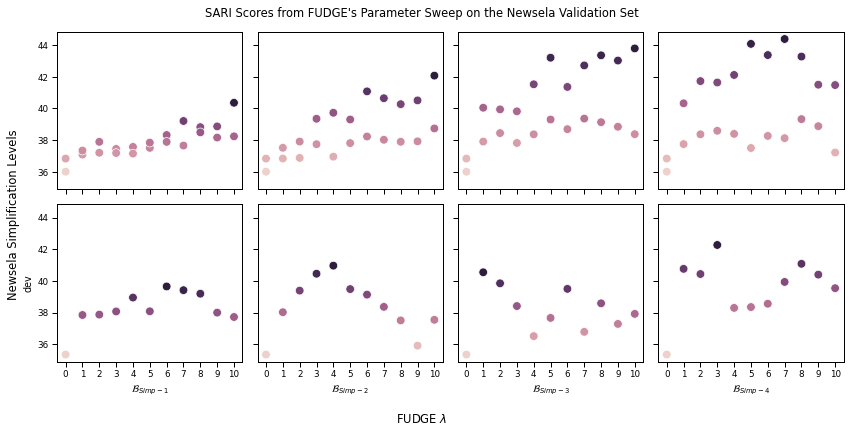

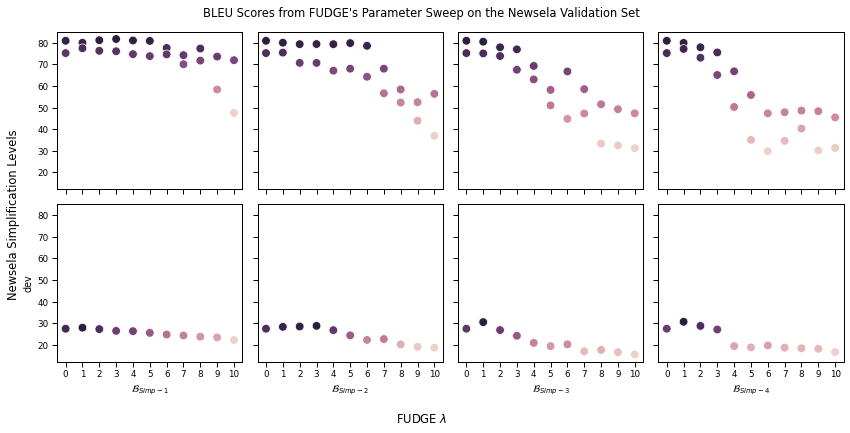

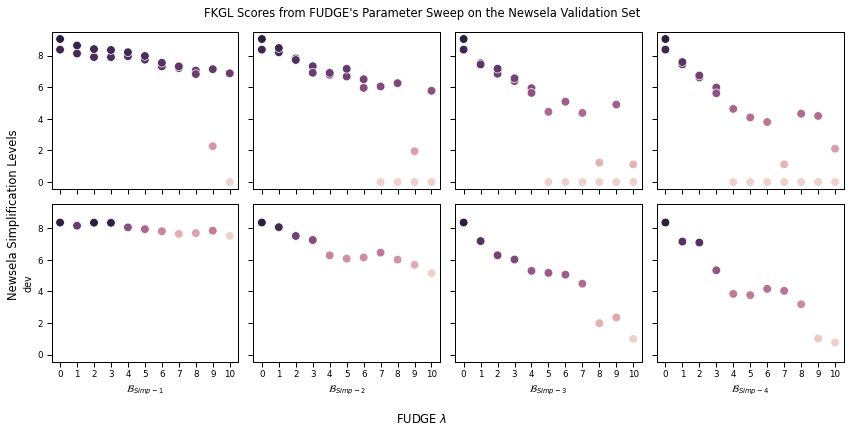

In [20]:
# June 3, 2022
# re-evaluating on Turk corpus

level = 'paragraphs'
fudge_format = 'newsela-lp'

csv_files = [
    f'/srv/scratch6/kew/ats/fudge/hpsearch/bart_large_muss_mined_en/{fudge_format}_l1_article_{level}/beam/results.csv',
    f'/srv/scratch6/kew/ats/fudge/hpsearch/bart_large_muss_mined_en/{fudge_format}_l2_article_{level}/beam/results.csv',
    f'/srv/scratch6/kew/ats/fudge/hpsearch/bart_large_muss_mined_en/{fudge_format}_l3_article_{level}/beam/results.csv',
    f'/srv/scratch6/kew/ats/fudge/hpsearch/bart_large_muss_mined_en/{fudge_format}_l4_article_{level}/beam/results.csv'
]

df = load_data(csv_files, ignore=['newsela_manual_v0_v1_dev', 'newsela_manual_v0_v2_dev',
                                 'newsela_manual_v0_v3_dev', 'newsela_manual_v0_v4_dev',])
df

plot_hp_sweep_results_facet_grid(df, metric='sari')#, outpath=plots_path)
plot_hp_sweep_results_facet_grid(df, metric='bleu')#, outpath=plots_path)
plot_hp_sweep_results_facet_grid(df, metric='fkgl')#, outpath=plots_path)

In [12]:
# plots for identifying optimal lambda value in paper 
level = 'paragraphs'
fudge_format = 'newsela-lp'

csv_files = [
    f'/srv/scratch6/kew/ats/fudge/hpsearch/bart_large_muss_mined_en/{fudge_format}_l1_article_{level}/beam/results.csv',
    f'/srv/scratch6/kew/ats/fudge/hpsearch/bart_large_muss_mined_en/{fudge_format}_l2_article_{level}/beam/results.csv',
    f'/srv/scratch6/kew/ats/fudge/hpsearch/bart_large_muss_mined_en/{fudge_format}_l3_article_{level}/beam/results.csv',
    f'/srv/scratch6/kew/ats/fudge/hpsearch/bart_large_muss_mined_en/{fudge_format}_l4_article_{level}/beam/results.csv'
]

df = load_data(csv_files, ignore=['wiki_manual_dev', 'turk_dev', 'asset_dev'])
df

plot_hp_sweep_results_facet_grid(df, metric='sari', outpath=plots_path)
plot_hp_sweep_results_facet_grid(df, metric='bleu', outpath=plots_path)
plot_hp_sweep_results_facet_grid(df, metric='fkgl', outpath=plots_path)


NameError: name 'csv_file' is not defined

rows=4, cols=4
sents
saved plot to /home/user/kew/INSTALLS/fudge/analysis/plots/hp_sweep_scores_sents_sari_facet.png
rows=4, cols=4
sents
saved plot to /home/user/kew/INSTALLS/fudge/analysis/plots/hp_sweep_scores_sents_bleu_facet.png
rows=4, cols=4
sents
saved plot to /home/user/kew/INSTALLS/fudge/analysis/plots/hp_sweep_scores_sents_fkgl_facet.png


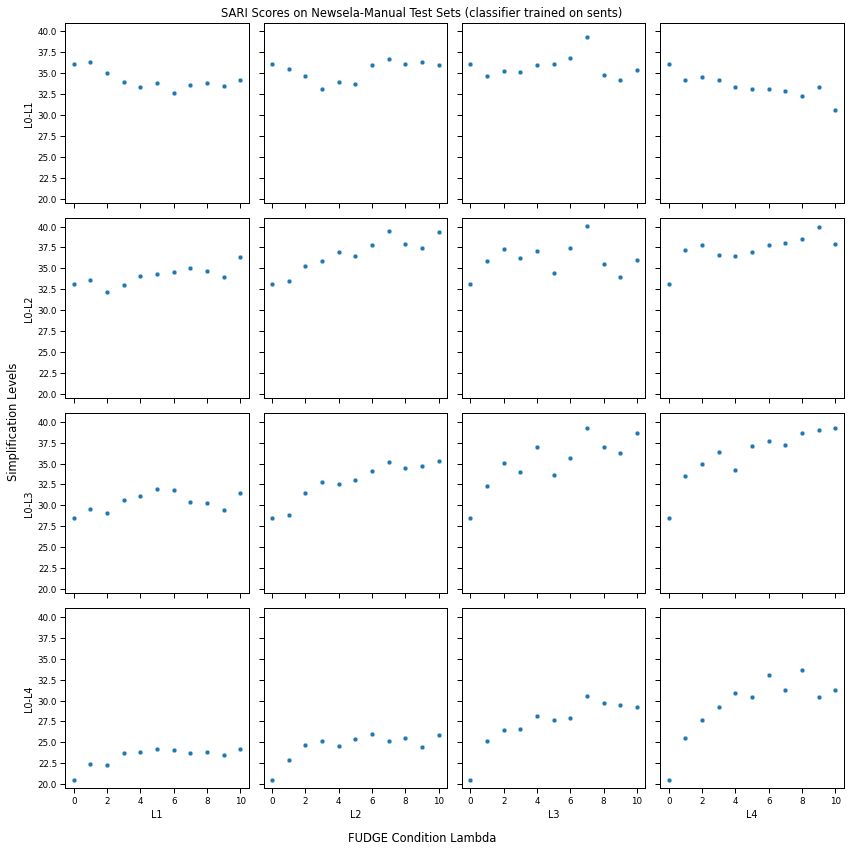

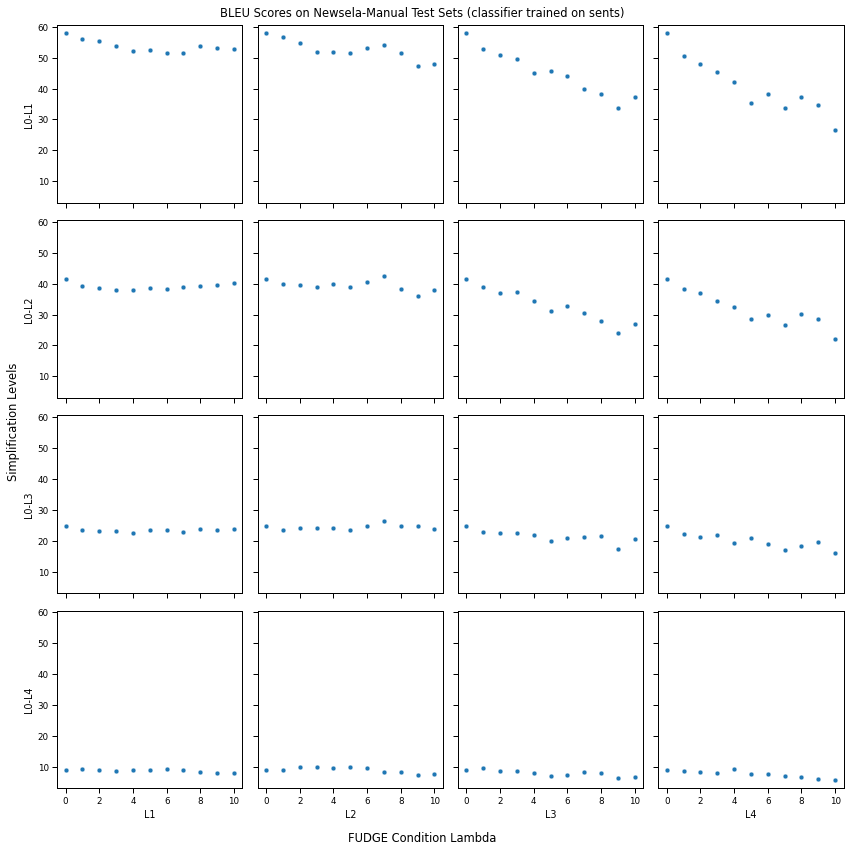

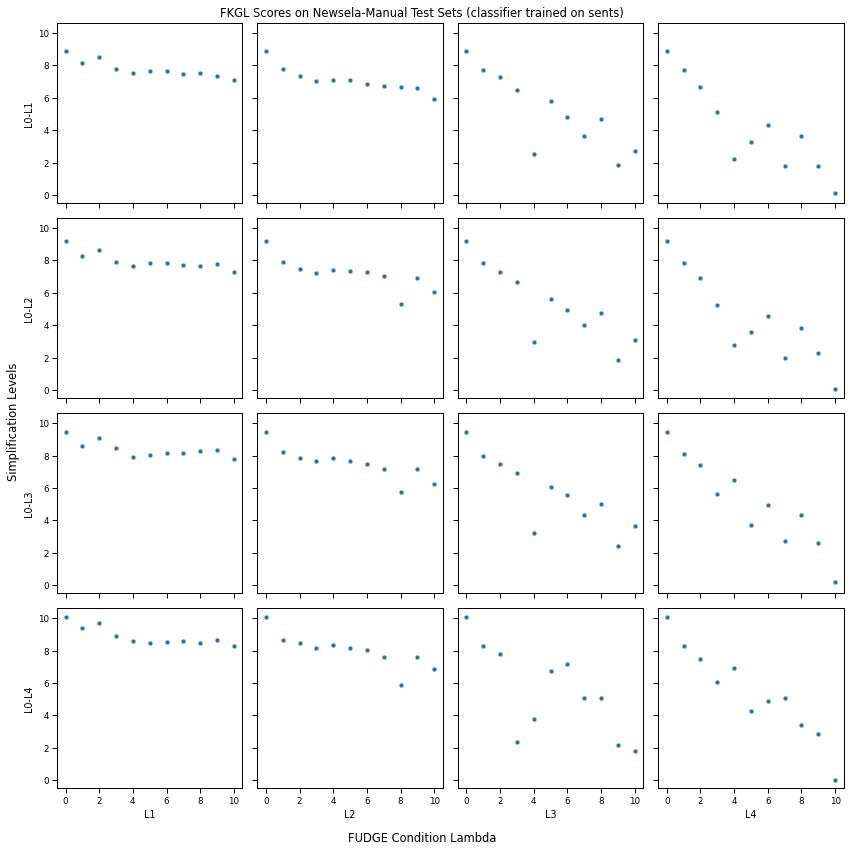

In [4]:
# level = 'paragraphs'
# format
# level = 'para_sents'
# # level = 'sentences'

# csv_files = [
#     f'/srv/scratch6/kew/ats/fudge/hpsearch/bart_large_muss_mined_en/newsela_l1_article_{level}/beam/results.csv',
#     f'/srv/scratch6/kew/ats/fudge/hpsearch/bart_large_muss_mined_en/newsela_l2_article_{level}/beam/results.csv',
#     f'/srv/scratch6/kew/ats/fudge/hpsearch/bart_large_muss_mined_en/newsela_l3_article_{level}/beam/results.csv',
#     f'/srv/scratch6/kew/ats/fudge/hpsearch/bart_large_muss_mined_en/newsela_l4_article_{level}/beam/results.csv'
# ]

# df = load_data(csv_files, ignore=['wiki_manual_dev', 'turk_dev', 'asset_dev'])
# df

# plot_hp_sweep_results_facet_grid(df, metric='sari', outpath=plots_path)
# plot_hp_sweep_results_facet_grid(df, metric='bleu', outpath=plots_path)
# plot_hp_sweep_results_facet_grid(df, metric='fkgl', outpath=plots_path)

In [188]:
# csv_file = '/srv/scratch6/kew/ats/fudge/hpsearch/bart_large_muss_mined_en/newsela_l1_article_paragraphs/beam/results.csv'
# # df = load_data(csv_file)
# # print(df['bleu'].describe())
# # print(df['fkgl'].describe())
# # print(df['sari'].describe())
# # plot_hp_sweep_harmonic_mean_results(df)
# plot_hp_sweep_results(csv_file)


77


,0,condition_lambda,sari
53,asset_dev,9,40.881938
10,newsela_manual_v0_v1_dev,10,39.328306
21,newsela_manual_v0_v2_dev,10,40.379187
32,newsela_manual_v0_v3_dev,10,36.597278
43,newsela_manual_v0_v4_dev,10,27.161617
65,turk_dev,10,37.477667
69,wiki_manual_dev,3,40.403337


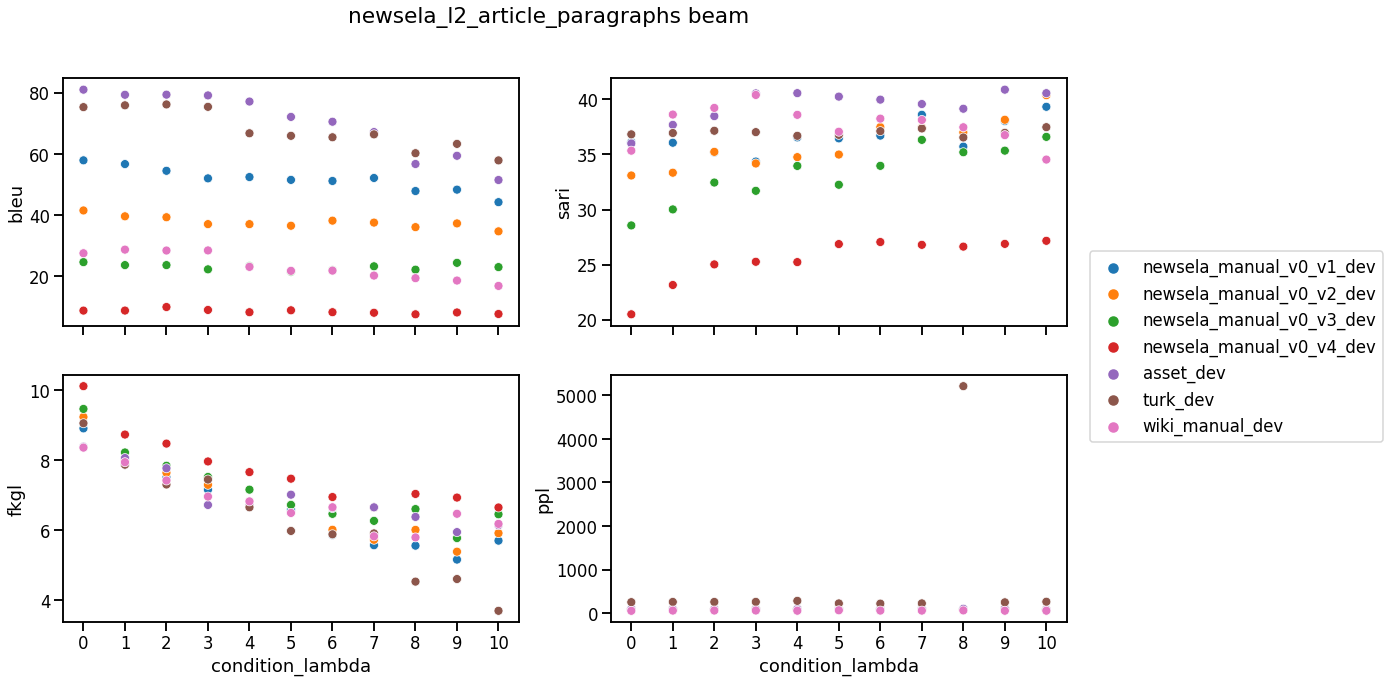

In [13]:
csv_file = '/srv/scratch6/kew/ats/fudge/hpsearch/bart_large_muss_mined_en/newsela_l2_article_paragraphs/beam/results.csv'
plot_hp_sweep_results(csv_file)

# df = load_data(csv_file)
# df = compute_harm_mean(df)
# plot_hp_sweep_harmonic_mean_results(df)



77


,0,condition_lambda,sari
50,asset_dev,6,44.797246
5,newsela_manual_v0_v1_dev,5,37.573643
16,newsela_manual_v0_v2_dev,5,40.653720
32,newsela_manual_v0_v3_dev,10,39.893734
42,newsela_manual_v0_v4_dev,9,32.378246
58,turk_dev,3,39.064612
68,wiki_manual_dev,2,41.923411


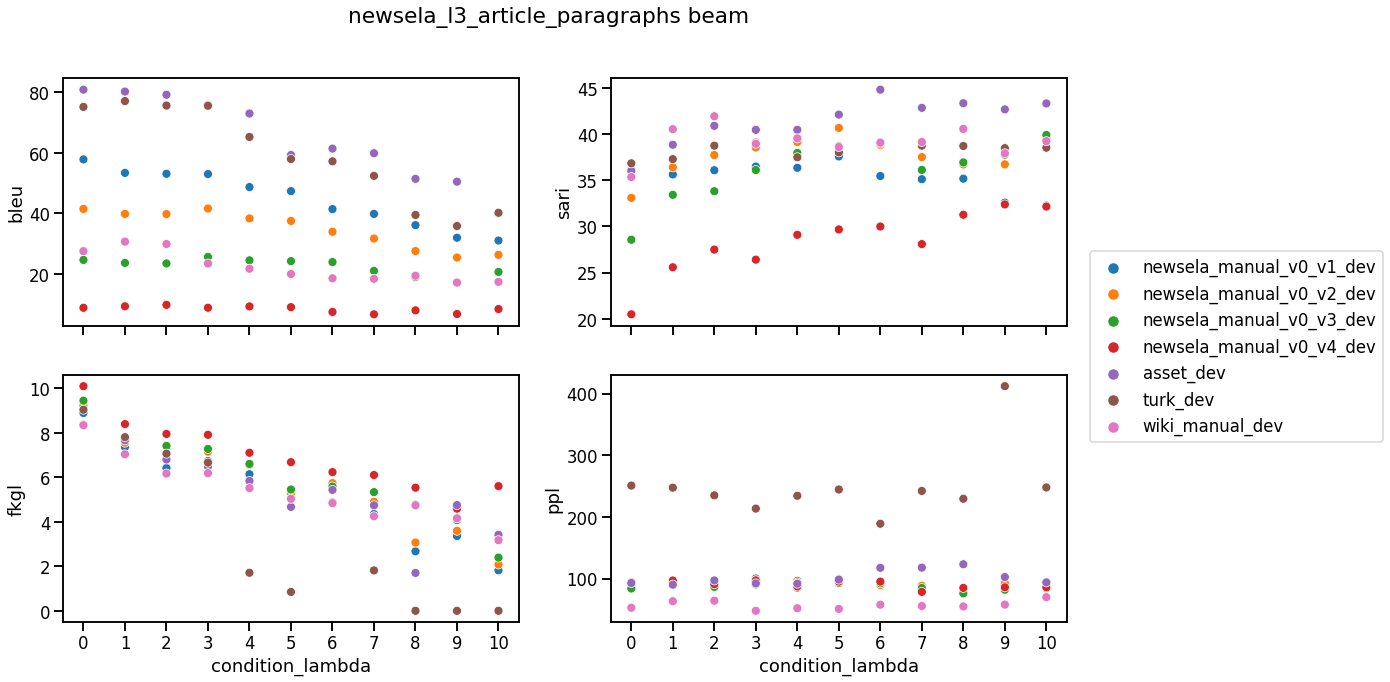

In [14]:
csv_file = '/srv/scratch6/kew/ats/fudge/hpsearch/bart_large_muss_mined_en/newsela_l3_article_paragraphs/beam/results.csv'
plot_hp_sweep_results(csv_file)

# df = load_data(csv_file)
# df = compute_harm_mean(df)
# plot_hp_sweep_harmonic_mean_results(df)


77


,0,condition_lambda,sari
48,asset_dev,4,42.146884
2,newsela_manual_v0_v1_dev,2,37.114137
16,newsela_manual_v0_v2_dev,5,39.384740
27,newsela_manual_v0_v3_dev,5,37.364993
40,newsela_manual_v0_v4_dev,7,31.234604
60,turk_dev,5,37.577409
72,wiki_manual_dev,6,41.222799


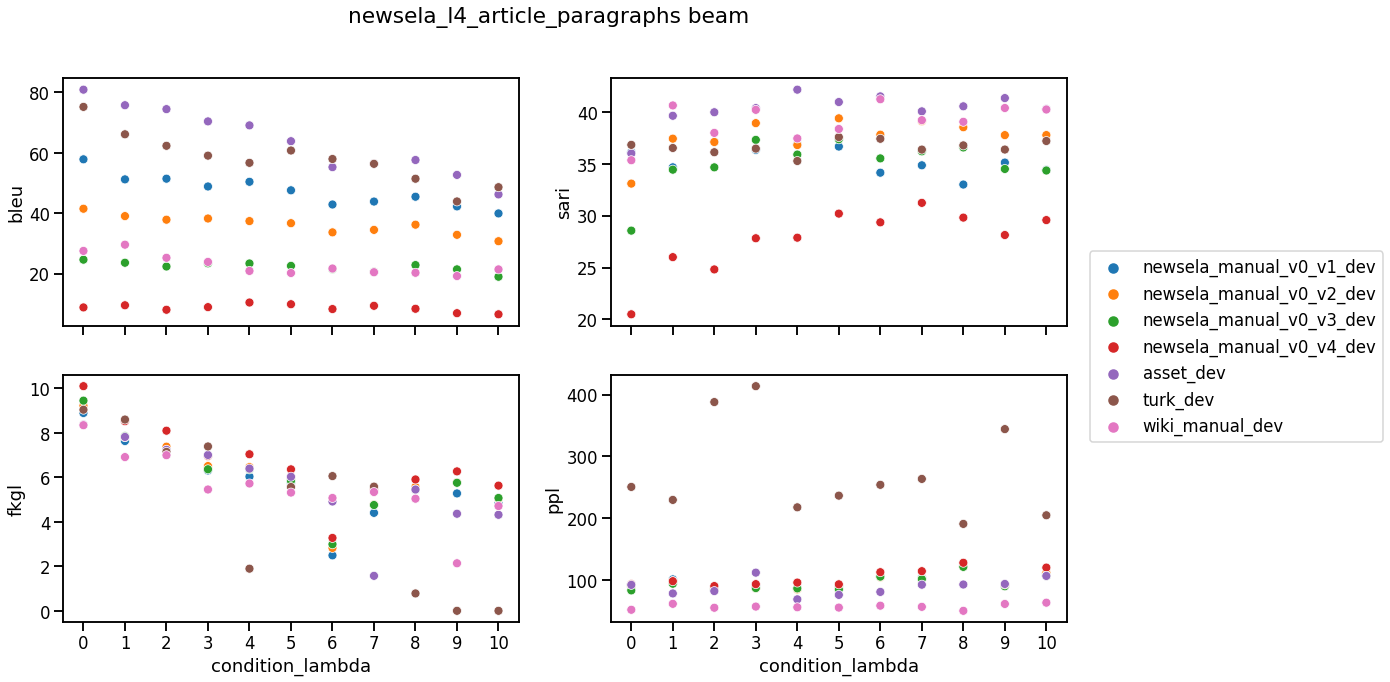

In [16]:
csv_file = '/srv/scratch6/kew/ats/fudge/hpsearch/bart_large_muss_mined_en/newsela_l4_article_paragraphs/beam/results.csv'
plot_hp_sweep_results(csv_file)
# print(df.sort_values('condition_lambda'))
# print(df.sort_values(0))


In [101]:
# print(combine_metrics(bleu_transform(40), sari_transform(50), fkgl_transform(8), [1, 1, 1]))
# print(combine_metrics(bleu_transform(40), sari_transform(45), fkgl_transform(4), [1, 1, 1]))
# print(combine_metrics(bleu_transform(40), sari_transform(40), fkgl_transform(12), [1, 1, 1]))
# print(combine_metrics(bleu_transform(40), sari_transform(35), fkgl_transform(6), [1, 1, 1]))




0.990712963553967
0.9909376966645689
0.9912028725314184
0.9915228713057664


77
77
                           0  condition_lambda       sari
1   newsela_manual_v0_v1_dev                 1  51.213169
69           wiki_manual_dev                 3  40.403337
18  newsela_manual_v0_v2_dev                 7  44.155058
29  newsela_manual_v0_v3_dev                 7  41.196644
40  newsela_manual_v0_v4_dev                 7  30.924660
53                 asset_dev                 9  40.881938
65                  turk_dev                10  37.477667
                           0  condition_lambda       sari
53                 asset_dev                 9  40.881938
1   newsela_manual_v0_v1_dev                 1  51.213169
18  newsela_manual_v0_v2_dev                 7  44.155058
29  newsela_manual_v0_v3_dev                 7  41.196644
40  newsela_manual_v0_v4_dev                 7  30.924660
65                  turk_dev                10  37.477667
69           wiki_manual_dev                 3  40.403337


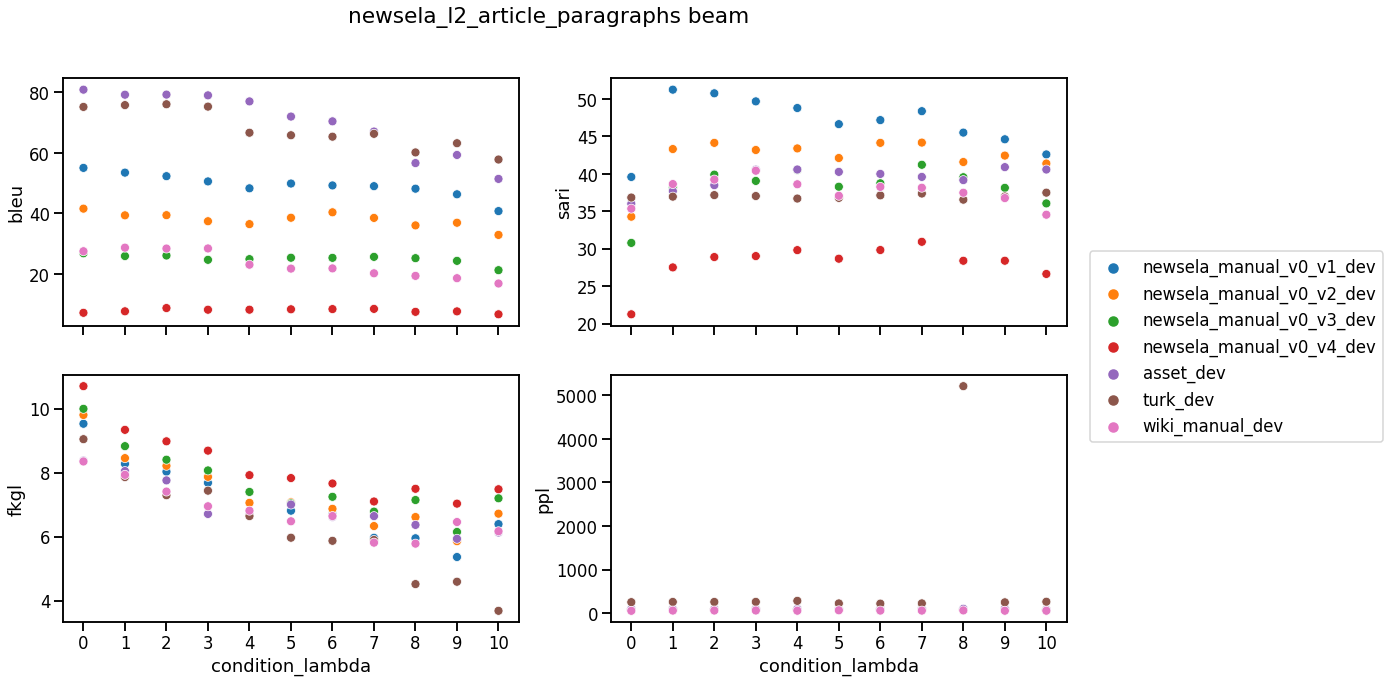

In [9]:
df = plot_hp_sweep_results('/srv/scratch6/kew/ats/fudge/hpsearch/bart_large_muss_mined_en/newsela_l2_article_paragraphs/beam/results.csv')
print(df.sort_values('condition_lambda'))
print(df.sort_values(0))


231
77
                            0  condition_lambda       sari
8    newsela_manual_v0_v1_dev                 2  50.179517
206           wiki_manual_dev                 2  41.923411
44   newsela_manual_v0_v2_dev                 3  45.526179
77   newsela_manual_v0_v3_dev                 3  41.935831
176                  turk_dev                 3  39.064612
152                 asset_dev                 6  44.797246
131  newsela_manual_v0_v4_dev                10  32.128790
                            0  condition_lambda       sari
152                 asset_dev                 6  44.797246
8    newsela_manual_v0_v1_dev                 2  50.179517
44   newsela_manual_v0_v2_dev                 3  45.526179
77   newsela_manual_v0_v3_dev                 3  41.935831
131  newsela_manual_v0_v4_dev                10  32.128790
176                  turk_dev                 3  39.064612
206           wiki_manual_dev                 2  41.923411


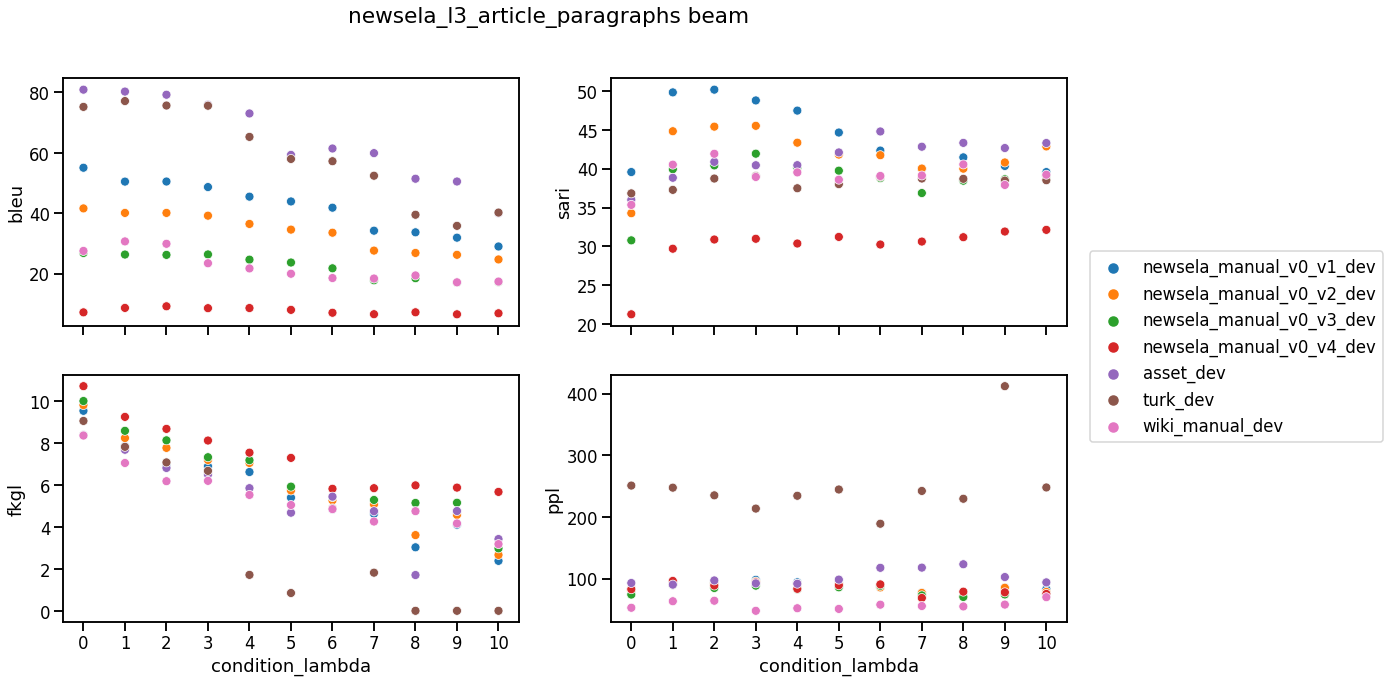

In [10]:
df = plot_hp_sweep_results('/srv/scratch6/kew/ats/fudge/hpsearch/bart_large_muss_mined_en/newsela_l3_article_paragraphs/beam/results.csv')
print(df.sort_values('condition_lambda'))
print(df.sort_values(0))


231
77
                            0  condition_lambda       sari
38   newsela_manual_v0_v2_dev                 1  45.677265
8    newsela_manual_v0_v1_dev                 2  50.087945
74   newsela_manual_v0_v3_dev                 2  41.576874
146                 asset_dev                 4  42.146884
182                  turk_dev                 5  37.577409
218           wiki_manual_dev                 6  41.222799
122  newsela_manual_v0_v4_dev                 7  31.527174
                            0  condition_lambda       sari
146                 asset_dev                 4  42.146884
8    newsela_manual_v0_v1_dev                 2  50.087945
38   newsela_manual_v0_v2_dev                 1  45.677265
74   newsela_manual_v0_v3_dev                 2  41.576874
122  newsela_manual_v0_v4_dev                 7  31.527174
182                  turk_dev                 5  37.577409
218           wiki_manual_dev                 6  41.222799


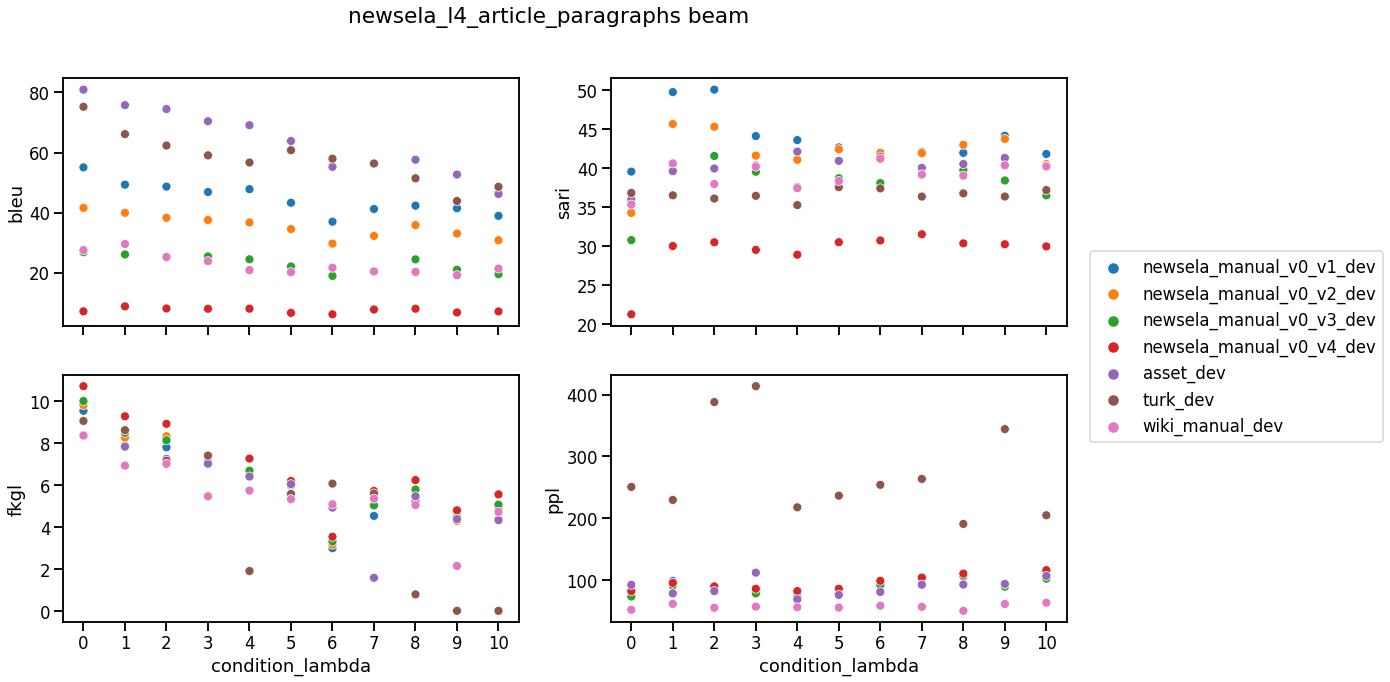

In [11]:
df = plot_hp_sweep_results('/srv/scratch6/kew/ats/fudge/hpsearch/bart_large_muss_mined_en/newsela_l4_article_paragraphs/beam/results.csv')
print(df.sort_values('condition_lambda'))
print(df.sort_values(0))


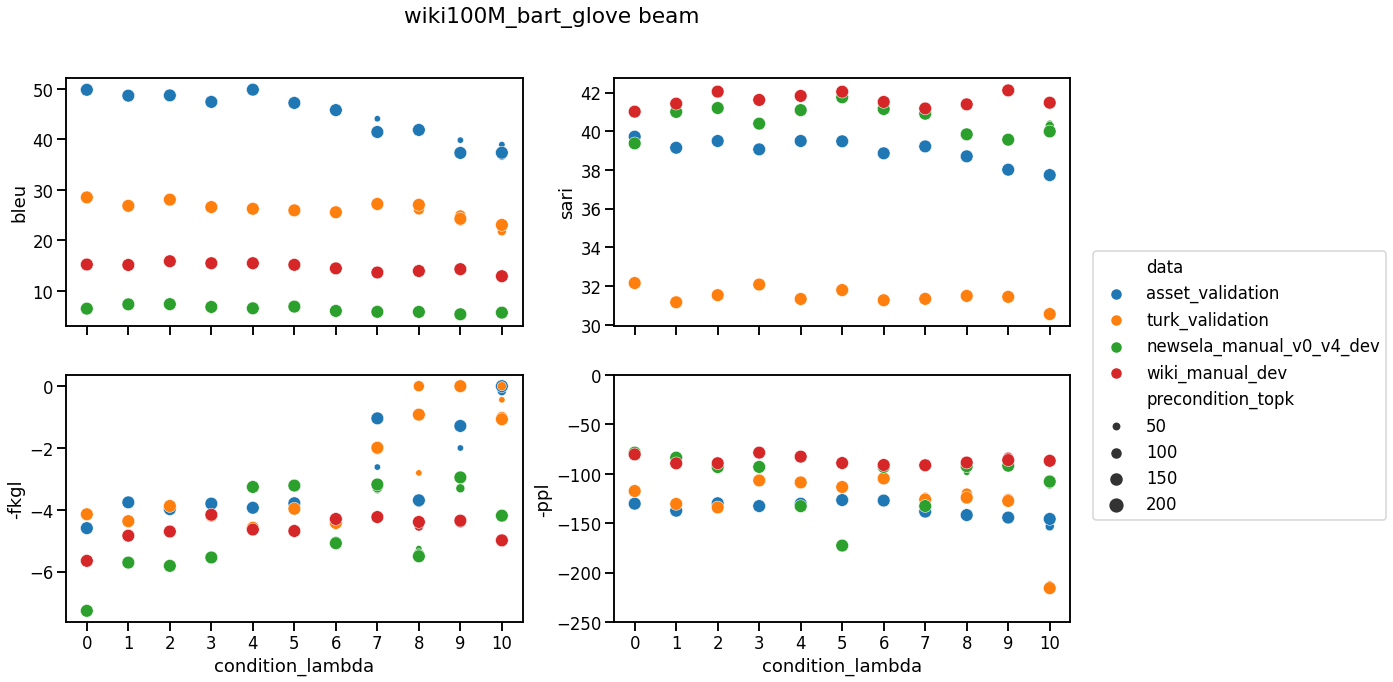

In [8]:

# precondition topk makes very little difference
# plot_hp_sweep_results('/srv/scratch6/kew/ats/fudge/hpsearch/bart_large_paraNMT_filt_fr/wiki100M_bart_glove/beam/results.csv', precondition_topk=True)


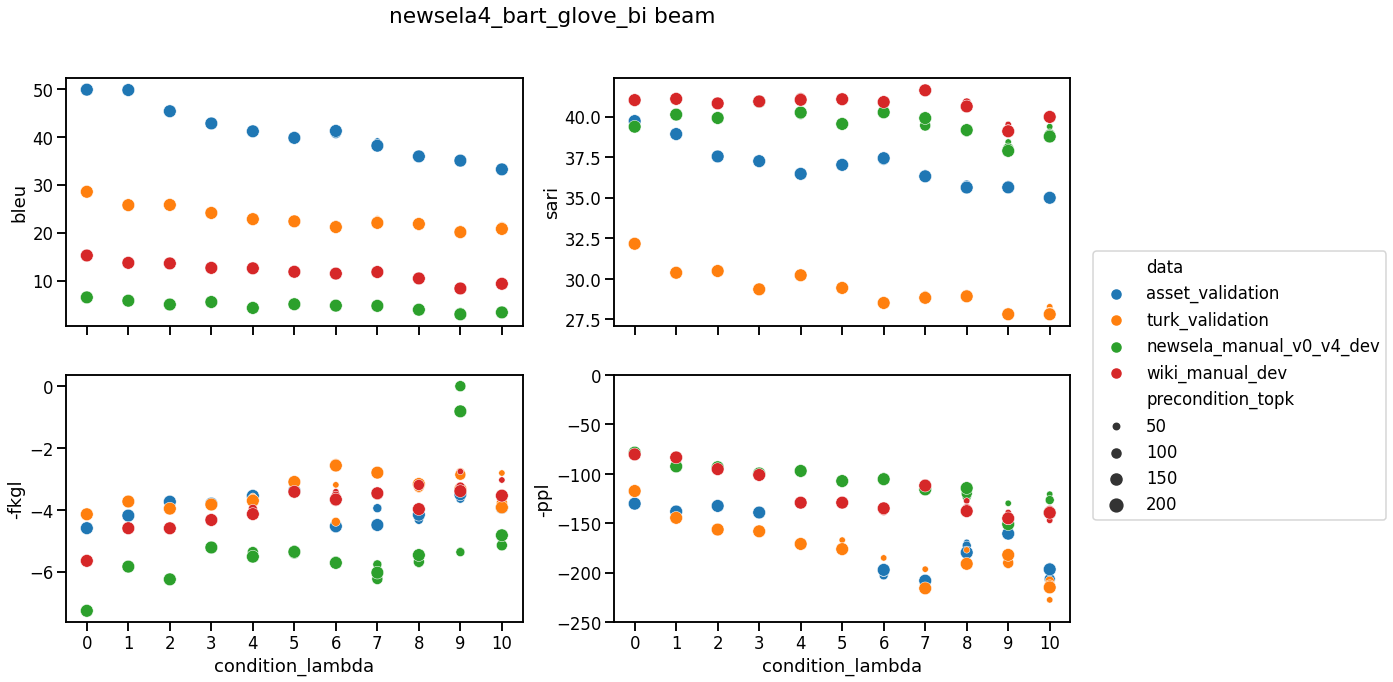

In [22]:

plot_hp_sweep_results('/srv/scratch6/kew/ats/fudge/hpsearch/bart_large_paraNMT_filt_fr/newsela4_bart_glove_bi/beam/results.csv')


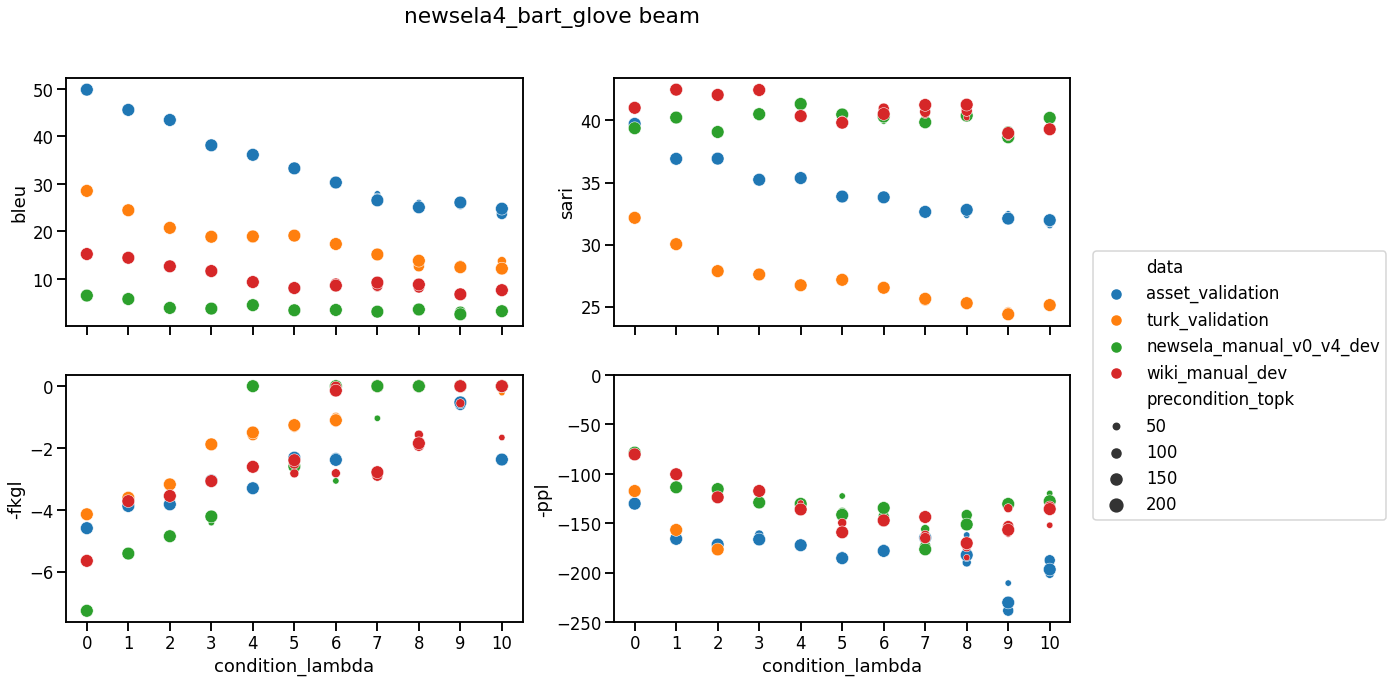

In [23]:

plot_hp_sweep_results('/srv/scratch6/kew/ats/fudge/hpsearch/bart_large_paraNMT_filt_fr/newsela4_bart_glove/beam/results.csv')


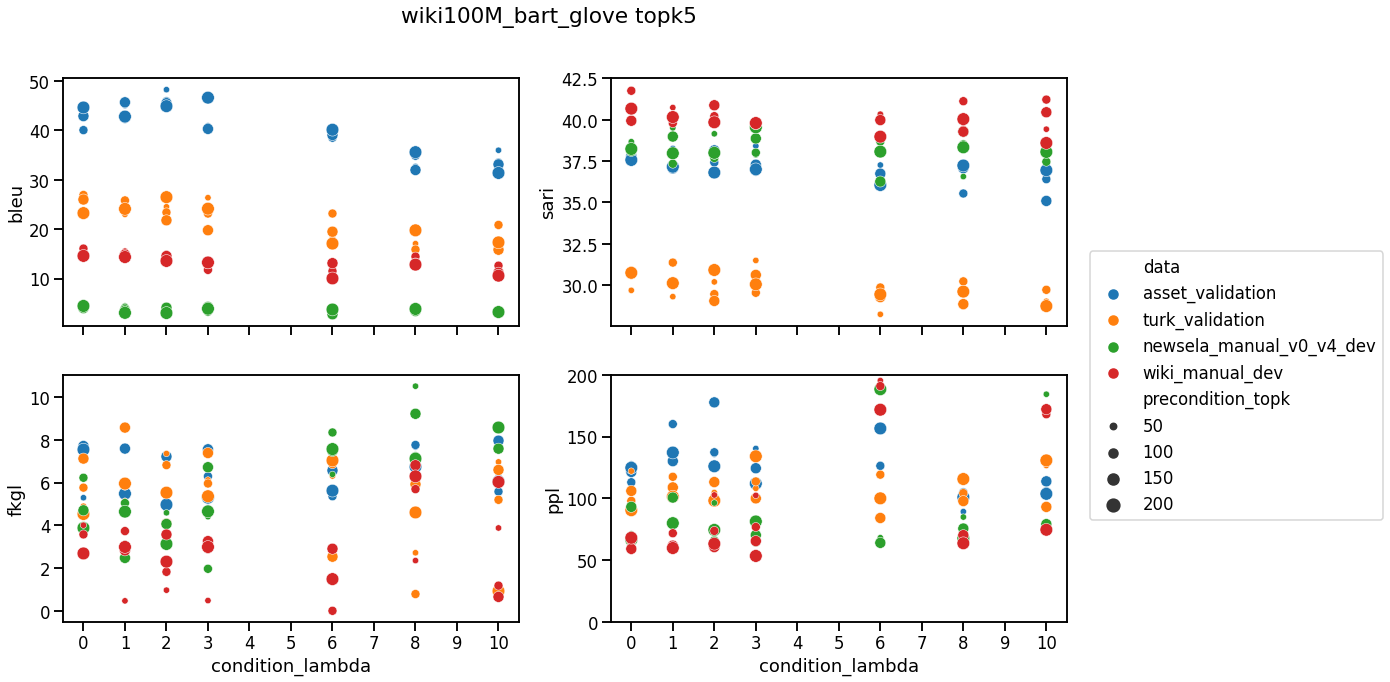

In [82]:

plot_hp_sweep_results('/srv/scratch6/kew/ats/fudge/hpsearch/bart_large_paraNMT_filt_fr/wiki100M_bart_glove/topk5/results.csv')
                      